In [75]:
#make sure about the cuda version
import numpy as np
import webdataset as wds
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms 
import os
import random
from itertools import islice
import matplotlib.pyplot as plt
import pickle
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
PATH_TO_DATA = "/glade/scratch/yiwenz/TransferLearningData/rand_sharded_data_all_Daily_dropna/" 
#PATH_TO_DATA = "/glade/scratch/yiwenz/TransferLearningData/rand_shard_data/"

# Initiate model

In [3]:
#8 channels: ['Red', 'Green', 'Blue', "NIR", "SWIR1","ndbi","ndvi","elevation"]

image_normalize = transforms.Normalize(
                  mean=[0, 0, 0, 0, 0, 0, 0, 4.1459e+02],
                  std=[1, 1, 1, 1, 1, 1, 1, 8.9265e+01]
)
image_rotate = transforms.RandomRotation(90)
#image mean(no clip of elev): [1.8218e-01,  1.4804e-01,  1.0894e-01,  2.6186e-01,  2.5452e-01, -9.3340e-03,  9.4021e-02,  4.1459e+02]
#image std (no clip of elev): [5.6672e-02, 4.0446e-02, 3.3400e-02, 6.2702e-02, 7.1029e-02, 5.7446e-02, 7.2435e-02, 8.9265e+01]

# forcing_normalize = transforms.Normalize(
#                   mean=[3.6346e+02, 8.3282e+02, 5.5716e-05, 9.6421e+04, 5.2780e-03, 3.0339e+02, 2.7644e+00],
#                   std=[6.5498e+01, 1.7130e+02, 3.7665e-04, 1.0908e+03, 2.9168e-03, 8.6245e+00, 1.5957e+00]
# )

forcing_mean = torch.from_numpy(np.array([3.6346e+02, 8.3282e+02, 5.5716e-05, 9.6421e+04, 5.2780e-03, 3.0339e+02, 2.7644e+00]))
forcing_std = torch.from_numpy(np.array([6.5498e+01, 1.7130e+02, 3.7665e-04, 1.0908e+03, 2.9168e-03, 8.6245e+00, 1.5957e+00]))
# forcing mean:[3.6346e+02, 8.3282e+02, 5.5716e-05, 9.6421e+04, 5.2780e-03, 3.0339e+02, 2.7644e+00]
# forcing std: [6.5498e+01, 1.7130e+02, 3.7665e-04, 1.0908e+03, 2.9168e-03, 8.6245e+00, 1.5957e+00]

lst_mean = torch.from_numpy(np.array([315.1010]))
lst_std = torch.from_numpy(np.array([10.9206]))
#lst mean:315.1010
#lst std: 10.9206

In [4]:
def create_train_test(path_to_data, train_perc, test_perc):
    random.seed(42)
    files = []
    for dirpath, dirnames, filenames in os.walk(path_to_data):
        files.extend(filenames)
    
    saturated = files[:-1] #-1
    unsaturated = files[-1] #-1
    
    dataset = wds.WebDataset(path_to_data + "/" + unsaturated)
    counter = 0
    for data in dataset:
        counter += 1
    
    total_files = counter + len(saturated) * 10000
    training_data = total_files * train_perc //10000
    test_data_files = total_files * test_perc //10000

    training_data = random.sample(files, int(training_data))
    test_data = [file for file in files if file not in training_data]
    test_data = random.sample(test_data, int(test_data_files))
    # Get sample sizes of train and test data
    training_samples = 0
    testing_samples = 0
    
    for path in training_data:
        if path in saturated:
            training_samples += 10000
        elif path in unsaturated:
            training_samples += counter
            
    for path in test_data:
        if path in saturated:
            testing_samples += 10000
        elif path in unsaturated:
            testing_samples += counter
            
            
    # Convert to filename lists 
    training_filepath = []
    for dat in training_data:
#        print(dat[6:12])
        training_filepath.append(dat[6:12])
    training_path = path_to_data + "shard-" + "{" + ",".join(training_filepath) + "}" + ".tar"
#    print(training_path)
    
    testing_filepath = []
    for dat in test_data:
        testing_filepath.append(dat[6:12])
    testing_path = path_to_data + "shard-{" + ",".join(testing_filepath) +"}.tar"
    train_data = wds.WebDataset(training_path).shuffle(30000, initial=30000).decode("rgb").rename(image="image.pyd", forcing="forcing.pyd", lst = "lst.pyd", key='__key__').to_tuple("image", "forcing", "lst", "key")
    test_data = wds.WebDataset(testing_path).decode("rgb").shuffle(30000, initial=30000).rename(image="image.pyd", forcing="forcing.pyd", lst = "lst.pyd", key='__key__').to_tuple("image", "forcing", "lst", "key")
    print(testing_path)
    
    predict_data_file = [file for file in files if file not in training_data]
    predict_filepath = []
    for dat in predict_data_file:
#        print(dat[6:12])
        predict_filepath.append(dat[6:12])
    predict_path = path_to_data + "shard-" + "{" + ",".join(predict_filepath) + "}" + ".tar"
    print(predict_path)
    predict_data = wds.WebDataset(predict_path).decode("rgb").rename(image="image.pyd", forcing="forcing.pyd", lst = "lst.pyd", key='__key__').to_tuple("image", "forcing", "lst", "key")
   
    
    return (train_data, training_samples), (test_data, testing_samples),predict_data
    
(train_data, training_samples_len), (test_data, testing_samples_len), predict_data = create_train_test(PATH_TO_DATA, 0.7, 0.1)

/glade/scratch/yiwenz/TransferLearningData/rand_sharded_data_all_Daily_dropna/shard-{000646,000274,000357,000433,000946,000030,000777,000418,000005,000466,000801,000371,000785,000306,000186,000957,000953,000431,000773,000015,000296,000510,000304,000841,000923,000280,000591,000898,000078,000535,000403,000882,000391,000644,000507,000100,000367,000940,000318,000492,000006,000092,000745,000713,000948,000562,000273,000746,000322,000361,000444,000605,000097,000912,000094,000342,000555,000179,000462,000059,000571,000107,000606,000681,000258,000846,000074,000636,000291,000241,000516,000742,000884,000874,000952,000206,000538,000614,000449,000656,000039,000081,000454,000248,000720,000791,000141,000890,000140,000463,000456,000139,000369,000023,000883}.tar
/glade/scratch/yiwenz/TransferLearningData/rand_sharded_data_all_Daily_dropna/shard-{000590,000163,000653,000296,000614,000369,000273,000463,000295,000540,000431,000366,000571,000039,000882,000941,000135,000720,000154,000878,000206,000912,000426

In [5]:
def process_data(image, forcing, lst, key):
    image, forcing, lst= image.to(DEVICE).to(torch.float32), forcing.to(DEVICE), lst.to(DEVICE)
    
    # Image Transformations
    image[:,7,] = torch.clip(image[:,7,], min=0, max=600)
    image[:,:5,] = torch.clip(image[:,:5,], min=0, max=1)
    image[:,5:7,] = torch.clip(image[:,5:7,], min=-1, max=1)
    image = image_normalize(image)
    image = image[:,:7,:] #np.array([5,6])
#    image = image_rotate(image)
    # Forcing Transformation
    forcing = torch.div(torch.sub(forcing, forcing_mean), forcing_std).to(torch.float32)
#    forcing = forcing.unsqueeze(2).unsqueeze(3)
#    forcing = forcing.repeat(1,1,33,33)
    # LST Transformation
#     lst = torch.div(torch.sub(lst, lst_mean), lst_std).to(torch.float32).view(-1, 1)
    lst = lst.view(-1, 1).to(torch.float32)
    month = tuple(int(x[2:4])-1 for x in key)
    month = torch.tensor(month).to(DEVICE).to(torch.int64)
    return image, forcing, lst, month

In [76]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
#        out = F.dropout2d(out, p=0.3)
        out = self.bn1(out)
        out = F.leaky_relu(out)

        out = self.conv2(out)
#        out = F.dropout2d(out, p=0.1)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.leaky_relu(out)

        return out

In [77]:
class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers: List[int],
        in_channel=7,
        forcing_shape = 7,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.flatten_shape = None
        
        self.conv1 = nn.Conv2d(in_channel, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool1 = nn.AvgPool2d(2)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
#        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
#        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool2 = nn.AdaptiveAvgPool2d((1,1))
        
#        self.fc0_1 = nn.Linear(128, out_features=256)
#        self.fc0_2 = nn.Linear(256, out_features=1)
        self.fc1 = nn.Linear(128+forcing_shape+12, out_features=256)
        self.drop1 = nn.Dropout(0.02)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = nn.ModuleList([])
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x: Tensor, forcing, one_hot_mon) -> Tensor:
        # See note [TorchScript super()]
#        x = self.conv0(x)
#        x = x.permute([0,3,1,2])
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.avgpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
#        x = self.layer3(x)
#        x = self.layer4(x)
        x = self.avgpool2(x)
        x = torch.flatten(x, 1)
#        x = self.drop1(x)
        x = F.leaky_relu(x)  
#        x = F.leaky_relu(x)
#        x = self.fc0_1(x)
#        x = F.leaky_relu(x)
#        x = self.fc0_2(x)
        x = torch.cat((x, forcing, one_hot_mon), dim=1)
#        x = self.fc0(x)      
        x = self.fc1(x)
        x = F.leaky_relu(x)        
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)

        return x

def resnet_simplified():
    return ResNet(BasicBlock,[3,3,0,0])

# Prediction on untrained data

In [72]:
from collections import OrderedDict
PATH_TO_MODEL="/glade/u/home/yiwenz/TransferLearning/resnet_dropna_6.pt"
def load_pretrained_weights(model,path):
    # if mode == 'online':
    #     """ Loads pretrained weights, and downloads if loading for the first time. """
    #     state_dict = torch.utils.model_zoo.load_url(url)
    #     state_dict.pop("fc.weight")
    #     state_dict.pop("fc.bias")
    #     weight = state_dict['conv1.weight'].clone()
    #     state_dict.pop("conv1.weight")
    #     model.load_state_dict(state_dict, strict=False)
    #     model.conv1.weight.data[:, :3] = weight
    #     model.conv1.weight.data[:, 3] = torch.mean(model.conv1.weight.data[:, :3],dim=1)
    # elif mode == 'local':
    new_state_dict = OrderedDict()
    state_dict = torch.load(path,map_location=torch.device('cpu'))
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    # load params
    model.load_state_dict(new_state_dict)
#    print(res.missing_keys)
#    assert set(res.missing_keys) == {"fc.weight", "fc.bias"}, "issue loading pretrained weights"
    print(f"Loaded pretrained weights.")

In [80]:
model=resnet_simplified()
load_pretrained_weights(model,PATH_TO_MODEL)

Loaded pretrained weights.


In [10]:
import datetime
import xarray as xr
import pandas as pd
import tqdm

PATH_TO_LATLONG = "/glade/u/home/yiwenz/TransferLearning/modis_lon_lat.csv"
BATCH_SIZE = 4096
DEVICE = "cpu"
predict_loader = torch.utils.data.DataLoader(predict_data, batch_size=BATCH_SIZE, num_workers=8)


model = model.to(DEVICE)
lst_mean = lst_mean.to(DEVICE)
lst_std = lst_std.to(DEVICE)
forcing_mean = forcing_mean.to(DEVICE)
forcing_std = forcing_std.to(DEVICE)
pred_all,lst_all,time_all,idx_all,key_all=[],[],[],[],[]

n_batch=0
with torch.no_grad():
    for idx, (image, forcing, lst, key) in enumerate(predict_loader):
        print(f'running batch #{n_batch}')
        image, forcing, lst, month = process_data(image, forcing, lst, key)
        one_hot_mon = F.one_hot(month, num_classes=12)
        pred = model.forward(image, forcing, one_hot_mon)
        pred = pred.numpy().reshape(-1).tolist()
        lst = lst.numpy().reshape(-1).tolist()
        time=list(datetime.datetime.strptime(x[:6],"%y%m%d") for x in key)
        idx=list(int(x[7:]) for x in key)
        pred_all.extend(pred)
        lst_all.extend(lst)
        time_all.extend(time)
        idx_all.extend(idx)
        key_all.extend(list(key))
        n_batch+=1
        
#        testloss = (pred-lst).item()
data_dic = {'key': key_all,'time':time_all, 'idx':idx_all, 'pred': pred_all, 'truth': lst_all}
df_data=pd.DataFrame(data=data_dic)
df_data['error']=df_data['pred']-df_data['truth']
latlong = pd.read_csv(PATH_TO_LATLONG, usecols=["lon", "lat"])
latlong=latlong.reset_index().rename(columns={'index':'idx'})
df_data=df_data.merge(latlong,on='idx').drop(columns=['idx'])
df_data.to_csv('lst_prediction.csv')

running batch #0
running batch #1
running batch #2
running batch #3
running batch #4
running batch #5
running batch #6
running batch #7
running batch #8
running batch #9
running batch #10
running batch #11
running batch #12
running batch #13
running batch #14
running batch #15
running batch #16
running batch #17
running batch #18
running batch #19
running batch #20
running batch #21
running batch #22
running batch #23
running batch #24
running batch #25
running batch #26
running batch #27
running batch #28
running batch #29
running batch #30
running batch #31
running batch #32
running batch #33
running batch #34
running batch #35
running batch #36
running batch #37
running batch #38
running batch #39
running batch #40
running batch #41
running batch #42
running batch #43
running batch #44
running batch #45
running batch #46
running batch #47
running batch #48
running batch #49
running batch #50
running batch #51
running batch #52
running batch #53
running batch #54
running batch #55
ru

# Error analysis

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and 1.0.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          0.0 and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
      
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
        
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def plot_data(df_data,date):
    df_plot=df_data[df_data['time'].str.contains(date)]
    df_plot=df_plot.groupby(['lon','lat']).mean().reset_index()
    fig, axes = plt.subplots(3,1,figsize=(9,15))

    #ser colormap for pred and truth
    min_lst=df_plot[['pred','truth']].min().min()
    max_lst=df_plot[['pred','truth']].max().max()

    #set colormap for error
    min_error=df_plot['error'].min()
    max_error=df_plot['error'].max()
    midpoint_error=1 - max_error/(max_error - min_error)
    cmap_error=shiftedColorMap(matplotlib.cm.coolwarm,midpoint=midpoint_error)
    
    #plot
    df_plot.plot(x="lon", y="lat", kind="scatter", c="pred",
            colormap="YlOrRd",ax=axes[0],vmin=min_lst,vmax=max_lst,title='prediction')
    df_plot.plot(x="lon", y="lat", kind="scatter", c="truth",
            colormap="YlOrRd",ax=axes[1],vmin=min_lst,vmax=max_lst,title='truth')
    df_plot.plot(x="lon", y="lat", kind="scatter", c="error",
            colormap=cmap_error,ax=axes[2],title='error')
    print(f'This is the average result of {date}.\nError ranges from {round(min_error,2)} to {round(max_error,2)}.')

In [15]:
import pandas as pd
import xarray as xr
PATH_TO_PRED='/glade/u/home/yiwenz/TransferLearning/lst_prediction.csv'
df_data=pd.read_csv(PATH_TO_PRED)
df_data

,time,lon,lat,key,pred,truth,error
0,2008-10-22,-112.274939,33.446369,081022_1623,312.529144,311.820007,0.709137
1,2004-12-15,-112.274939,33.446369,041215_1623,297.700378,297.179993,0.520386
2,2005-09-30,-112.274939,33.446369,050930_1623,319.917816,320.619995,-0.702179
3,2008-10-25,-112.274939,33.446369,081025_1623,312.935547,311.320007,1.615540
4,2009-10-21,-112.274939,33.446369,091021_1623,310.457336,309.899994,0.557343
...,...,...,...,...,...,...,...
2879995,2017-09-21,-112.210398,33.447016,170921_1629,319.489868,321.579987,-2.090118
2879996,2017-09-07,-112.210398,33.447016,170907_1629,324.922607,322.200012,2.722595
2879997,2017-09-16,-112.210398,33.447016,170916_1629,321.246307,320.279999,0.966309
2879998,2018-12-24,-112.116247,33.655334,181224_509,297.538361,298.640015,-1.101654


This is the average result of 12-29.
Error ranges from -3.92 to 22.67


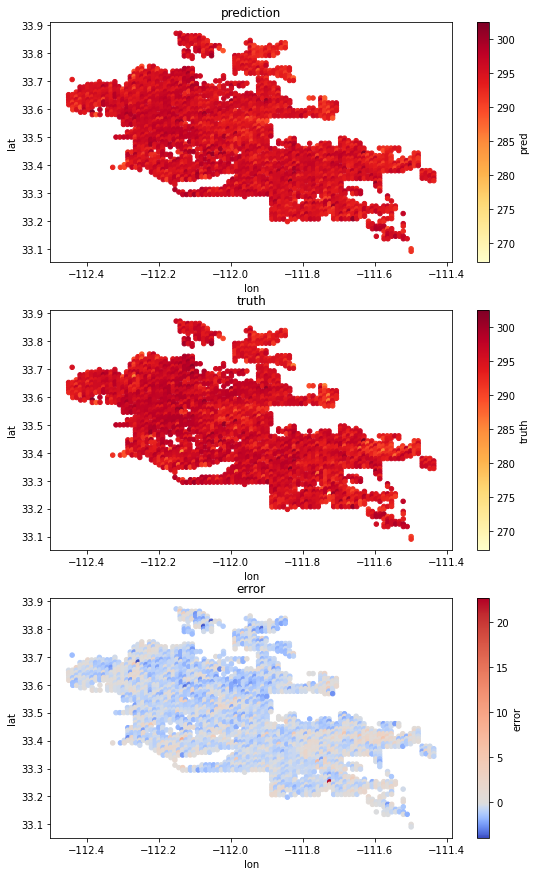

In [85]:
plot_data(df_data,date='12-29')

In [71]:
#Percent of data with error between -2 and 2
df_data[(df_data.error<=2) & (df_data.error>=-2)].count()[0]/df_data.count()[0]

0.6448809027777778

In [60]:
#RMSE of the whole dataset
rmse=np.sqrt(((df_data.pred-df_data.truth)**2).sum()/2880000)
rmse

2.5106121054534096

In [32]:
df_data.sort_values(by='error',ascending=False).head(20)

,time,lon,lat,key,pred,truth,error
1296561,2004-12-29,-111.724638,33.252376,041229_2767,289.850677,267.179993,22.670685
2120928,2003-03-02,-111.530702,33.136096,030302_2964,299.880341,279.839996,20.040344
620037,2010-02-26,-111.965580,33.683660,100226_380,303.606781,283.739990,19.866791
2162526,2012-04-09,-112.213167,33.645403,120409_552,319.963654,300.140015,19.823639
8454,2010-02-26,-111.965680,33.692678,100226_333,303.352661,283.739990,19.612671
752428,2017-03-08,-112.354029,33.689032,170308_304,311.778809,292.380005,19.398804
591951,2012-04-09,-112.341843,33.598980,120409_834,322.077667,302.859985,19.217682
276562,2010-02-03,-112.143964,33.303341,100203_2578,301.758728,282.619995,19.138733
1799022,2012-04-09,-112.212788,33.618350,120409_729,319.238800,300.140015,19.098785
387662,2010-02-03,-112.100892,33.294711,100203_2630,303.424011,284.519989,18.904022
